In [23]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [24]:
model = BabyMAKROModelClass(name='baseline') # create an instance of the model

In [25]:
par = model.par
ss = model.ss
sol = model.sol

# Find steady state

In [26]:
model.find_ss(0.50,do_print=True)

ss.S = 7.44
ss.L = 56.28
ss.delta_L = 0.07
ss.v = 16.52
ss.m_v = 0.23
ss.r_K = 0.14
ss.r_ell = 2.71
ss.ell = 55.87
ss.w = 2.68
ss.G = 100.00
ss.B_G = 50.00
ss.tau = 0.68
solving for household behavior: result.converged = True
ss.C = 49.27
ss.B = 119.18
ss.K = 557.43
ss.I = 55.74
ss.Y = 229.56
ss.X = nan
ss.M = nan
par.phi = 0.988


**Household behavior:**

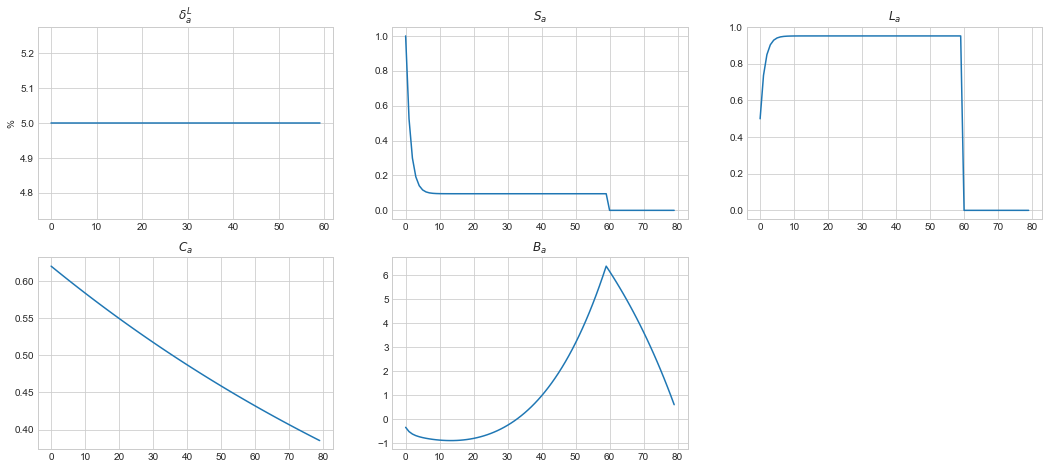

In [27]:
fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot(model.par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('$\delta^L_a$')

ax = fig.add_subplot(3,3,2)
ax.plot(model.ss.S_a)
ax.set_title('$S_a$')

ax = fig.add_subplot(3,3,3)
ax.plot(model.ss.L_a)
ax.set_title('$L_a$')

ax = fig.add_subplot(3,3,4)
ax.plot(model.ss.C_a)
ax.set_ylabel('')
ax.set_title('$C_a$')

ax = fig.add_subplot(3,3,5)
ax.plot(model.ss.B_a)
ax.set_ylabel('')
ax.set_title('$B_a$');

# Speed and error tests

In [28]:
model.set_exo_ss()
model.set_unknowns_ss()

**Python evaluation:**

In [29]:
%time model.evaluate_blocks(py=True)

CPU times: user 1.59 s, sys: 12.7 ms, total: 1.6 s
Wall time: 1.61 s


**Check errors:**

In [30]:
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 2.63e-13
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 7.11e-15
mkt_clearing        : abs. max = 0.00e+00


**First numba evaluation:**

In [31]:
%time model.evaluate_blocks()

CPU times: user 17.7 s, sys: 192 ms, total: 17.9 s
Wall time: 17.9 s


**Time:**

In [32]:
%timeit model.evaluate_blocks()
%timeit model.get_errors()

4.73 ms ± 39.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
22.4 µs ± 145 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [33]:
%timeit model.evaluate_blocks(py=True)

190 ms ± 952 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Find an impulse-response

**Calculate Jacobian:**

In [34]:
model.calc_jac(do_print=True)

Jacobian calculated in 12.3 secs secs


Only needs to be calculated once.

**Set exogenous variables:**

In [35]:
model.set_exo_ss()

Here we shock export demand:

In [36]:
# Tshock = 50
# shock = 0.01*ss.chi
# persistence = 0.8**np.arange(Tshock)
# sol.chi[:Tshock] = ss.chi + shock*persistence

Here we shock the import price of consumption goods (P_M_C):

In [37]:
#Tshock = 60
#shock = 0.1*ss.P_M_C
#persistence = 0.85**np.arange(Tshock)
#sol.P_M_C[:Tshock] = ss.P_M_C + shock*persistence

In [38]:
def shock_func_ny(ssvalue, solvalue, time_start =0, time_span = 50, shock_size = 0.1, persistence_size =0.8):
        shock_f = shock_size
        persistence_f = persistence_size ** np.arange(time_span)
        solvalue[time_start:time_start+time_span] = ssvalue + shock_f*persistence_f

In [39]:
# guide: shock_func(ssvalue, solvalue, time_start =0, time_span = 50, shock_size = 0.1, persistence_size =0.8)
shock_func_ny(ss.tau,sol.tau, shock_size = -0.1, persistence_size =0.5)

Check errors when guessing at steady state -> excess demand

In [40]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 7.49e+00
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 8.88e-15
mkt_clearing        : abs. max = 0.00e+00


**Find IRF:**

In [41]:
model.find_IRF()

initial:
   max. abs. error = 7.49e+00
    0.00e+00 in bargaining_cond
    7.49e+00 in Bq_match
    0.00e+00 in FOC_capital_agency
    8.88e-15 in FOC_K_ell
    0.00e+00 in mkt_clearing

it = 0
 solve: t1-t0 = 0.2 secs
   max. abs. error = 7.49e+00
    2.53e-05 in bargaining_cond
    1.91e-01 in Bq_match
    1.46e-04 in FOC_capital_agency
    8.13e-04 in FOC_K_ell
    1.62e-02 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 1
 solve: t1-t0 = 0.2 secs
   max. abs. error = 1.91e-01
    1.37e-06 in bargaining_cond
    2.67e-03 in Bq_match
    1.12e-05 in FOC_capital_agency
    2.92e-04 in FOC_K_ell
    4.98e-03 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 2
 solve: t1-t0 = 0.1 secs
   max. abs. error = 4.98e-03
    2.04e-07 in bargaining_cond
    5.65e-04 in Bq_match
    3.40e-06 in FOC_capital_agency
    5.04e-05 in FOC_K_ell
    9.06e-04 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 3
 s

**Plot:**

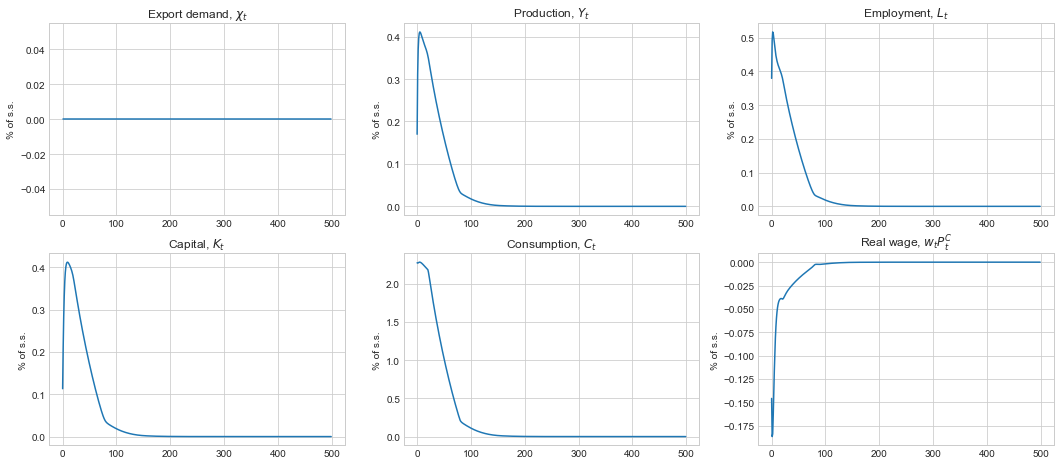

In [42]:
T_IRF = 500

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand, $\chi_t$')

ax = fig.add_subplot(3,3,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(3,3,3)
ax.plot((sol.L[:T_IRF]/ss.L-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Employment, $L_t$')

ax = fig.add_subplot(3,3,4)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(3,3,5)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(3,3,6)
ax.plot(((sol.w[:T_IRF]/sol.P_C[:T_IRF])/(ss.w/ss.P_C)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Real wage, $w_tP^C_t$');